# Web Scraping Rightmove

#### Using python's BeautifulSoup to extract information about properties on sale in London Borough of Greenwich; mainly done for collecting data to use in classification ML mini project later.

Data gathered on: 14th April 2023, 20:51.

In [1]:
#Module for http requests 
import requests

#Module to parse html
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

Let's begin by defining a function which can extract the information that we require from the advertisement page of the specific property being looked at. The features of the property we will extract are: Price, Property Type, Bedrooms, Bathrooms, Size.

In [2]:
#A function used to extract the required information about properties using the advertisement webpage: Price, Property Type, Bedrooms, Bathrooms, Size

#The parameter 'advert_url' is the link to the advertisement page of the property being looked at
def info_extract(advert_url):
    
    #Dictionary to store the required information as key value pair. E.g. {..., "Bedrooms": 2, ...}
    information = {}
    
    #Http request and extracting the html of the advert page using .text
    advert_html = requests.get(advert_url).text
    
    #BeautifulSoup object to parse the html
    advert_soup = BeautifulSoup(advert_html, 'lxml')
    
    #Extracting the price of the property
    price = advert_soup.find('div', class_ = "_1gfnqJ3Vtd1z40MlC0MzXu").find('span').text
    information["Price (£)"] = price.strip('£')
    
    #Extracting other information about the property: type, bedrooms etc
    for info in advert_soup.find_all('dl', class_ = "_3gIoc-NFXILAOZEaEjJi1n"):
        if 'PROPERTY' in info.text:
            information["Property Type"] = info.text[13:]
        if 'BEDROOM' in info.text:
            information["Bedrooms"] = info.text.split('×')[-1]
        if 'BATHROOM' in info.text:
            information["Bathrooms"] = info.text.split('×')[-1]
        if 'SIZE' in info.text:
            information["Size, sq. ft."] = info.text.split()[0][4:]
    
    return information

Rightmove only allows access to (/displays) a maximum of 42 search pages, where each search page contains the url to around 24 advertisement pages. Every search page can be accessed by changing the value of the 'index' parameter present on it's url. The 'index' parameter starts from 0 and ends at 984, increasing in multiples of 24. Thus, next we run a loop from 0 to 41 and store the url for each search pages.

In [3]:
#Storing links, in a list, to access the 42 search pages
all_links = []

#For loop to access the url to each search page by changing the 'index' parameter
for index in range(0,42):
    page_url = f"https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E61226&sortType=6&index={24*index}&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords="
    all_links.append(page_url)

#Displaying the links to first five search pags
all_links[0:5]

['https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E61226&sortType=6&index=0&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=',
 'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E61226&sortType=6&index=24&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=',
 'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E61226&sortType=6&index=48&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=',
 'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E61226&sortType=6&index=72&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=',
 'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E61226&sortType=6&index=96&propertyTypes=&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=']

See the image at the bottom of the notebook to get a clear picture of how the nested for loop below is functioning.

In [4]:
#Stores the dictionary returned by 'info_extract(#)' function, containing the features of each property
info = []

#Nested for loop: First loop Accesses each of the 42 search pages individually while the second (inner) loop accesses each of the advertisement pages within the given search page
for search_page_url in all_links:
    
    #Getting the html for each search page
    search_page_html = requests.get(search_page_url).text
    
    #Creating BeautifulSoup object for each search page html
    search_page_soup = BeautifulSoup(search_page_html, 'lxml')
    
    #Obtaining the url to each of the advertisements in this particular search page: Using list comprehension instead of another for loop
    advert_urls = [f"https://www.rightmove.co.uk{url['href']}" for url in search_page_soup.find_all('a', class_ = "propertyCard-priceLink propertyCard-salePrice", href = True)]
    
    #Inner for loop: Extracting information for each advertisement found in this particular search page and saving it in the 'info' list
    for advert_url in advert_urls:
        info.append( info_extract(advert_url) )        

Now that we have extracted all the required information, we simply need to save it as a csv file for latter use.

In [5]:
#Creating the pandas DataFrame object using the 'info' list
properties = pd.DataFrame(info)

#Saving the DataFrame as a csv file
properties.to_csv('rightmove_Greenwich.csv', index = False)

In [6]:
#Viewing the DataFrame
properties.head(10)

,Price (£),Property Type,Bedrooms,Bathrooms,"Size, sq. ft."
0,"449,995",Apartment,1,1,551
1,"750,000",Flat,2,2,"1,276"
2,"300,000",Flat,2,1,NaN
3,"385,000",NaN,1,1,NaN
4,"550,000",Apartment,2,2,NaN
5,"265,000",Flat,1,1,NaN
6,"395,000",Terraced,2,1,NaN
7,"350,000",Apartment,NaN,1,NaN
8,"350,000",Flat,3,1,NaN
9,"265,000",Flat,2,1,NaN


In [8]:
#Different types of properties in Greenwich
properties["Property Type"].value_counts()

Apartment                       319
Flat                            295
Terraced                        166
Semi-Detached                   121
End of Terrace                   41
Detached                         32
Maisonette                       27
House                            18
Town House                        8
Penthouse                         4
Ground Flat                       4
Studio                            3
Retirement Property               2
Bungalow                          1
Cottage                           1
Plot                              1
Detached Bungalow                 1
Ground Maisonette                 1
Link Detached House               1
House of Multiple Occupation      1
Semi-Detached Bungalow            1
Name: Property Type, dtype: int64

## Visualising the nested loop

Let's have a closer look at how the nested for loop extracts the information we require. 

We have a tree data structure where the root is the 'all_links' list. Each element of 'all_links' list is it's children; 'page_url' (for the search pages). Each 'page_url' has it's own children; the url to the adverts contained on that search page, 'advert_url'. Then, the function 'info_extract' acts on every 'advert_url' to extract the information regarding the properties on sale. 

To summarise, the nested for loop simply does a depth first traversal of this graph and adds the required information into the 'info' list at each leaf node.

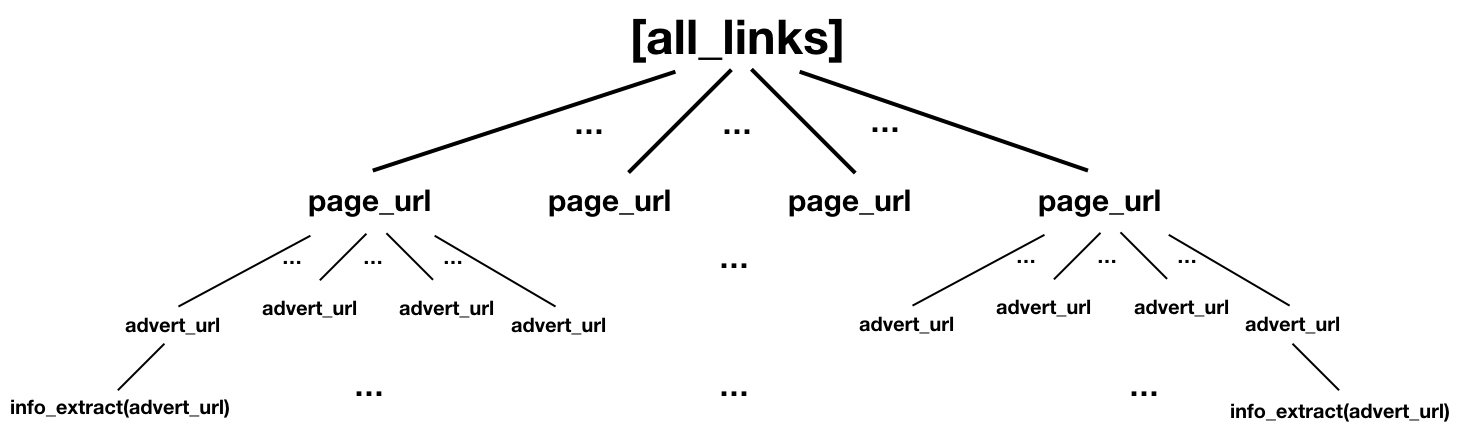

## Author
Abhay Shrestha